=== Train UIDs ===
['10' '13' '11' '34' '15' '42' '0' '50' '45' '23' '26' '20' '7' '8' '6'
 '46' '14' '2' '19' '19' '19' '26' '25' '4' '49' '13' '7' '47' '37' '3'
 '45' '37' '42' '15' '19' '34' '38' '41' '8' '17' '40' '38' '1' '51' '18'
 '41' '45' '18' '15' '44' '25' '30' '15' '53' '0' '47' '12' '42' '54' '19'
 '44' '0' '1' '0' '0' '38' '41' '6' '24' '13' '33' '6' '55' '36' '41' '52'
 '7' '52' '22' '54' '22' '25' '8' '36' '18' '16' '54' '18' '4' '35' '9'
 '12' '41' '41' '16' '34' '19' '7' '10' '9' '11' '43' '47' '38' '23' '15'
 '13' '11' '12' '4' '34' '10' '27' '24' '17' '43' '54' '42' '43' '14' '40'
 '35' '16' '9' '10' '18' '41' '18' '41' '16' '40' '11' '7' '6' '9' '49'
 '19' '6' '19' '32' '20' '8' '48' '14' '46' '35' '25' '3' '44' '51' '37'
 '32' '17' '24' '9' '49' '29' '0' '42' '42' '14' '44' '35' '49' '44' '4'
 '10' '13' '17' '51' '11' '24' '32' '13' '54' '35' '11' '14' '35' '51'
 '27' '15' '33' '28' '31' '55' '29' '23' '30' '55' '11' '22' '48' '31' '5'
 '42' '50' '3' '17' '6' '38'

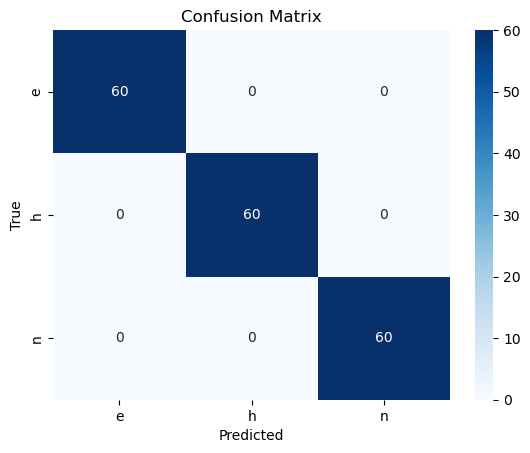


Classification Report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00        60
           h       1.00      1.00      1.00        60
           n       1.00      1.00      1.00        60

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.signal import stft
import seaborn as sns
import matplotlib.pyplot as plt

def load_raw_ppg(url):
    raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    df = pd.read_csv(raw_url)
    df = df[df['JNC'].notna()]
    df['JNC'] = df['JNC'].str.lower()
    le = LabelEncoder()
    df['BP_class'] = le.fit_transform(df['JNC'])
    ppg_cols = [c for c in df.columns if c.startswith("PPG_")]
    X = df[ppg_cols].astype(float).values
    y = df['BP_class'].astype(int).values
    label_names = le.classes_
    if 'UID' in df.columns:
        uids = df['UID'].values
    else:
        uids = df.index.astype(str).values
    return X, y, label_names, uids

def balance_classes(X, y, uids, N=300):
    Xb, yb, ub = [], [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        sel = np.random.choice(idx, N, replace=(len(idx) < N))
        Xb.append(X[sel])
        yb.append(y[sel])
        ub.append(uids[sel])
    return np.vstack(Xb), np.hstack(yb), np.hstack(ub)

def extract_tf_features(sig, fs=1000):
    f, t, Zxx = stft(sig, fs=fs, nperseg=33, noverlap=16)
    Zxx += 1e-12
    IF = np.angle(Zxx).mean(axis=0)
    P = np.abs(Zxx)**2
    P /= (P.sum(axis=0, keepdims=True) + 1e-12)
    SE = -np.sum(P * np.log(P + 1e-12), axis=0)
    return np.stack([IF, SE], axis=1).astype(np.float32)

class PPGBinary(Dataset):
    def __init__(self, X, y):
        self.features = [extract_tf_features(x) for x in X]
        self.labels = y
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.features[i], self.labels[i]

class ResNetBlock1D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(ch)
        self.conv2 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(ch)
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + res)

class ResNetClassifier(nn.Module):
    def __init__(self, in_ch=2, num_classes=4, num_blocks=4, embed_dim=64):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, embed_dim, kernel_size=1),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(*[ResNetBlock1D(embed_dim) for _ in range(num_blocks)])
        self.pool   = nn.AdaptiveAvgPool1d(1)
        self.head   = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(embed_dim//2, num_classes)
        )
    def forward(self, x):
        x = x.transpose(1,2)  # (B, T, C) -> (B, C, T)
        x = self.stem(x)
        x = self.blocks(x)
        x = self.pool(x)
        return self.head(x)

def train_and_evaluate(url, epochs=50, N=300):
    X, y, label_names, uids = load_raw_ppg(url)
    X, y, uids = balance_classes(X, y, uids, N=N)

    # train/test split (UIDs 포함)
    X_train, X_test, y_train, y_test, uid_train, uid_test = train_test_split(
        X, y, uids, test_size=0.2, stratify=y, random_state=42)

    # UID 출력
    print("=== Train UIDs ===")
    print(uid_train)
    print("\n=== Test UIDs ===")
    print(uid_test)

    # 겹치는 UID 확인
    overlap = np.intersect1d(uid_train, uid_test)
    print(f"\n=== Overlapping UIDs ({len(overlap)}) ===")
    print(overlap)

    train_ds = PPGBinary(X_train, y_train)
    test_ds  = PPGBinary(X_test,  y_test)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=32)

    device    = 'cuda' if torch.cuda.is_available() else 'cpu'
    model     = ResNetClassifier(num_classes=len(np.unique(y))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()  # .long()로 캐스팅
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            correct    += (pred.argmax(1) == yb).sum().item()
            total      += yb.size(0)
        print(f"[Epoch {epoch:02d}] Loss: {total_loss/total:.4f}, Acc: {correct/total:.4f}")

    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(out)
            all_trues.extend(yb.numpy())

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_trues, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_trues, all_preds, target_names=label_names))

if __name__ == "__main__":
    url = "https://github.com/MyungKyuYi/Experiment/blob/main/D2_P56_11900.csv"
    train_and_evaluate(url, epochs=50, N=300)


[Epoch 01] Loss: 0.8594, Acc: 0.5900
[Epoch 02] Loss: 0.6423, Acc: 0.7278
[Epoch 03] Loss: 0.4237, Acc: 0.8444
[Epoch 04] Loss: 0.2778, Acc: 0.9078
[Epoch 05] Loss: 0.2263, Acc: 0.9333
[Epoch 06] Loss: 0.1418, Acc: 0.9656
[Epoch 07] Loss: 0.0658, Acc: 0.9833
[Epoch 08] Loss: 0.0344, Acc: 0.9944
[Epoch 09] Loss: 0.0342, Acc: 0.9967
[Epoch 10] Loss: 0.1211, Acc: 0.9622
[Epoch 11] Loss: 0.0379, Acc: 0.9956
[Epoch 12] Loss: 0.0125, Acc: 0.9989
[Epoch 13] Loss: 0.0088, Acc: 1.0000
[Epoch 14] Loss: 0.0063, Acc: 1.0000
[Epoch 15] Loss: 0.0054, Acc: 1.0000
[Epoch 16] Loss: 0.0180, Acc: 0.9967
[Epoch 17] Loss: 0.0156, Acc: 0.9978
[Epoch 18] Loss: 0.3363, Acc: 0.8867
[Epoch 19] Loss: 0.1152, Acc: 0.9589
[Epoch 20] Loss: 0.0354, Acc: 0.9944
[Epoch 21] Loss: 0.0119, Acc: 1.0000
[Epoch 22] Loss: 0.0064, Acc: 1.0000
[Epoch 23] Loss: 0.0049, Acc: 1.0000
[Epoch 24] Loss: 0.0037, Acc: 1.0000
[Epoch 25] Loss: 0.0038, Acc: 1.0000
[Epoch 26] Loss: 0.0035, Acc: 1.0000
[Epoch 27] Loss: 0.0028, Acc: 1.0000
[

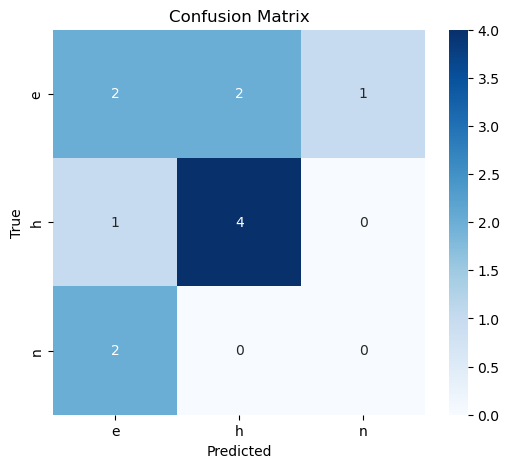


Classification Report:
              precision    recall  f1-score   support

           e       0.40      0.40      0.40         5
           h       0.67      0.80      0.73         5
           n       0.00      0.00      0.00         2

    accuracy                           0.50        12
   macro avg       0.36      0.40      0.38        12
weighted avg       0.44      0.50      0.47        12



In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.signal import stft
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 라벨 처리 (Subject ID 컬럼 자동 인식)
def load_raw_ppg(url):
    raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    df = pd.read_csv(raw_url)

    # 결측 JNC 제거 및 소문자 변환
    df = df[df['JNC'].notna()].copy()
    df['JNC'] = df['JNC'].str.lower()

    # 라벨 인코딩
    le = LabelEncoder()
    df['BP_class'] = le.fit_transform(df['JNC'])
    label_names = le.classes_

    # PPG 신호 및 레이블 추출
    ppg_cols = [c for c in df.columns if c.startswith("PPG_")]
    X = df[ppg_cols].astype(float).values
    y = df['BP_class'].astype(int).values

    # Subject-wise split을 위한 그룹(Subject ID) 컬럼 자동 탐색
    for cand in ('subject_ID', 'SubjectID', 'subj_id', 'UID'):
        if cand in df.columns:
            groups = df[cand].values
            break
    else:
        raise KeyError("DataFrame에 subject-wise split용 컬럼이 없습니다. 'subject_ID' 또는 'SubjectID' 등을 확인하세요.")

    return X, y, groups, label_names

# 2. 클래스 균형화 (train 세트에만 적용)
def balance_classes(X, y, N=300):
    Xb, yb = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        sel = np.random.choice(idx, N, replace=(len(idx) < N))
        Xb.append(X[sel])
        yb.append(y[sel])
    return np.vstack(Xb), np.hstack(yb)

# 3. TF 특징 추출
def extract_tf_features(sig, fs=1000):
    f, t, Zxx = stft(sig, fs=fs, nperseg=33, noverlap=16)
    Zxx += 1e-12
    IF = np.angle(Zxx).mean(axis=0)
    P = np.abs(Zxx) ** 2
    P /= (P.sum(axis=0, keepdims=True) + 1e-12)
    SE = -np.sum(P * np.log(P + 1e-12), axis=0)
    return np.stack([IF, SE], axis=1).astype(np.float32)

# 4. Dataset 정의
class PPGBinary(Dataset):
    def __init__(self, X, y):
        # features는 float32 numpy → tensor로 변환
        self.features = [torch.from_numpy(extract_tf_features(x)) for x in X]
        # labels 전체를 long tensor로 변환
        self.labels = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.features[i], self.labels[i]


# 5. ResNet 모델
class ResNetBlock1D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(ch)
        self.conv2 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(ch)
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + res)

class ResNetClassifier(nn.Module):
    def __init__(self, in_ch=2, num_classes=4, num_blocks=4, embed_dim=64):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, embed_dim, kernel_size=1),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(*[ResNetBlock1D(embed_dim) for _ in range(num_blocks)])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )
    def forward(self, x):
        x = x.transpose(1,2)  # (B, T, C) → (B, C, T)
        x = self.stem(x)
        x = self.blocks(x)
        x = self.pool(x)
        return self.head(x)

# 6. 학습 및 평가 함수 (subject-wise split 적용)
def train_and_evaluate(url, epochs=50, N=300):
    # 데이터 로드
    X, y, groups, label_names = load_raw_ppg(url)

    # UID(Subject ID)를 기준으로 train/test 분리
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    # train 세트만 클래스 균형화
    X_train, y_train = balance_classes(X_train, y_train, N=N)

    # Dataset & DataLoader
    train_ds = PPGBinary(X_train, y_train)
    test_ds  = PPGBinary(X_test,  y_test)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=32)

    # 모델/Optimizer/손실함수 준비
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ResNetClassifier(num_classes=len(label_names)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 학습 루프
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)                  # features는 float32
            yb = yb.long().to(device)           # labels를 long으로 변환
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
        print(f"[Epoch {epoch:02d}] Loss: {total_loss/total:.4f}, Acc: {correct/total:.4f}")

    # 평가
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.long()                 # CPU evaluation 시에도 long
            out = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(out)
            all_trues.extend(yb.numpy())

    # Confusion Matrix 시각화
    cm = confusion_matrix(all_trues, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()

    # Classification Report 출력
    print("\nClassification Report:")
    print(classification_report(all_trues, all_preds, target_names=label_names))

# 7. 실행
if __name__ == "__main__":
    url = "https://github.com/MyungKyuYi/Experiment/blob/main/D2_P56_11900.csv"
    train_and_evaluate(url, epochs=50, N=300)



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.signal import stft
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 라벨 처리 (Subject ID 컬럼 자동 인식)
def load_raw_ppg(url):
    raw_url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    df = pd.read_csv(raw_url)

    df = df[df['JNC'].notna()].copy()
    df['JNC'] = df['JNC'].str.lower()

    le = LabelEncoder()
    df['BP_class'] = le.fit_transform(df['JNC'])
    label_names = le.classes_

    ppg_cols = [c for c in df.columns if c.startswith("PPG_")]
    X = df[ppg_cols].astype(float).values
    y = df['BP_class'].astype(int).values

    # Subject-wise split을 위한 그룹 컬럼 자동 탐색
    for cand in ('subject_ID', 'SubjectID', 'subj_id', 'UID'):
        if cand in df.columns:
            groups = df[cand].values
            break
    else:
        raise KeyError("Subject ID 컬럼('subject_ID' 등)이 없습니다.")

    return X, y, groups, label_names

# 2. 클래스 균형화 (train 세트에만 적용)
def balance_classes(X, y, N=300):
    Xb, yb = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        sel = np.random.choice(idx, N, replace=(len(idx) < N))
        Xb.append(X[sel])
        yb.append(y[sel])
    return np.vstack(Xb), np.hstack(yb)

# 3. TF 특징 추출
def extract_tf_features(sig, fs=1000):
    f, t, Zxx = stft(sig, fs=fs, nperseg=33, noverlap=16)
    Zxx += 1e-12
    IF = np.angle(Zxx).mean(axis=0)
    P = np.abs(Zxx) ** 2
    P /= (P.sum(axis=0, keepdims=True) + 1e-12)
    SE = -np.sum(P * np.log(P + 1e-12), axis=0)
    return np.stack([IF, SE], axis=1).astype(np.float32)

# 4. Dataset 정의
class PPGBinary(Dataset):
    def __init__(self, X, y):
        self.features = [torch.from_numpy(extract_tf_features(x)) for x in X]
        self.labels = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.features[i], self.labels[i]

# 5. ResNet 모델
class ResNetBlock1D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(ch)
        self.conv2 = nn.Conv1d(ch, ch, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(ch)
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + res)

class ResNetClassifier(nn.Module):
    def __init__(self, in_ch=2, num_classes=4, num_blocks=4, embed_dim=64):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, embed_dim, kernel_size=1),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(*[ResNetBlock1D(embed_dim) for _ in range(num_blocks)])
        self.pool   = nn.AdaptiveAvgPool1d(1)
        self.head   = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )
    def forward(self, x):
        x = x.transpose(1,2)  # (B, T, C) → (B, C, T)
        x = self.stem(x)
        x = self.blocks(x)
        x = self.pool(x)
        return self.head(x)

# 6. 10-fold subject-wise Cross-Validation
def cross_validate(url, folds=10, epochs=20, N=300):
    X, y, groups, label_names = load_raw_ppg(url)
    gkf = GroupKFold(n_splits=folds)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
        print(f"\n=== Fold {fold}/{folds} ===")

        # split
        X_train, y_train = X[train_idx], y[train_idx]
        X_val,   y_val   = X[val_idx],   y[val_idx]

        # balance train set
        X_train, y_train = balance_classes(X_train, y_train, N=N)

        # DataLoader
        train_ds = PPGBinary(X_train, y_train)
        val_ds   = PPGBinary(X_val,   y_val)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=32)

        # model/opt
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = ResNetClassifier(num_classes=len(label_names)).to(device)
        opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
        crit  = nn.CrossEntropyLoss()

        # train
        for epoch in range(1, epochs+1):
            model.train()
            total_loss, correct, total = 0,0,0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = crit(pred, yb)
                opt.zero_grad(); loss.backward(); opt.step()
                total_loss += loss.item() * xb.size(0)
                correct    += (pred.argmax(1)==yb).sum().item()
                total      += yb.size(0)
            if epoch % 10 == 0 or epoch==1:
                print(f" Epoch {epoch:02d} | Loss: {total_loss/total:.4f}, Acc: {correct/total:.4f}")

        # validate
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                out = model(xb).argmax(dim=1).cpu().numpy()
                all_preds.extend(out)
                all_true.extend(yb.numpy())

        # metrics
        cm = confusion_matrix(all_true, all_preds)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f"Fold {fold} Confusion")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

        print(classification_report(all_true, all_preds, target_names=label_names))

if __name__ == "__main__":
    url = "https://github.com/MyungKyuYi/Experiment/blob/main/D2_P56_11900.csv"
    cross_validate(url, folds=10, epochs=50, N=300)
